In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/crime-cast-forecasting-crime-categories/sample.csv
/kaggle/input/crime-cast-forecasting-crime-categories/train.csv
/kaggle/input/crime-cast-forecasting-crime-categories/test.csv


# Importing

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from scipy.stats import chi2_contingency
from sklearn.feature_selection import f_classif
from imblearn.over_sampling import SMOTE
from sklearn.tree import plot_tree
from collections import Counter
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from scipy.stats import f_oneway
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [3]:
train_df = pd.read_csv("/kaggle/input/crime-cast-forecasting-crime-categories/train.csv")
test_df = pd.read_csv('/kaggle/input/crime-cast-forecasting-crime-categories/test.csv')
train_df.head()

,Location,Cross_Street,Latitude,Longitude,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Area_Name,Reporting_District_no,...,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Premise_Description,Weapon_Used_Code,Weapon_Description,Status,Status_Description,Crime_Category
0,4500 CARPENTER AV,NaN,34.1522,-118.3910,03/09/2020 12:00:00 AM,03/06/2020 12:00:00 AM,1800.0,15.0,N Hollywood,1563.0,...,75.0,M,W,101.0,STREET,NaN,NaN,IC,Invest Cont,Property Crimes
1,45TH ST,ALAMEDA ST,34.0028,-118.2391,02/27/2020 12:00:00 AM,02/27/2020 12:00:00 AM,1345.0,13.0,Newton,1367.0,...,41.0,M,H,216.0,SWAP MEET,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes
2,600 E MARTIN LUTHER KING JR BL,NaN,34.0111,-118.2653,08/21/2020 12:00:00 AM,08/21/2020 12:00:00 AM,605.0,13.0,Newton,1343.0,...,67.0,M,B,501.0,SINGLE FAMILY DWELLING,NaN,NaN,IC,Invest Cont,Property Crimes
3,14900 ORO GRANDE ST,NaN,34.2953,-118.4590,11/08/2020 12:00:00 AM,11/06/2020 12:00:00 AM,1800.0,19.0,Mission,1924.0,...,61.0,M,H,101.0,STREET,NaN,NaN,IC,Invest Cont,Property Crimes
4,7100 S VERMONT AV,NaN,33.9787,-118.2918,02/25/2020 12:00:00 AM,02/25/2020 12:00:00 AM,1130.0,12.0,77th Street,1245.0,...,0.0,X,X,401.0,MINI-MART,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Location               20000 non-null  object 
 1   Cross_Street           3448 non-null   object 
 2   Latitude               20000 non-null  float64
 3   Longitude              20000 non-null  float64
 4   Date_Reported          20000 non-null  object 
 5   Date_Occurred          20000 non-null  object 
 6   Time_Occurred          20000 non-null  float64
 7   Area_ID                20000 non-null  float64
 8   Area_Name              20000 non-null  object 
 9   Reporting_District_no  20000 non-null  float64
 10  Part 1-2               20000 non-null  float64
 11  Modus_Operandi         17259 non-null  object 
 12  Victim_Age             20000 non-null  float64
 13  Victim_Sex             17376 non-null  object 
 14  Victim_Descent         17376 non-null  object 
 15  Pr

In [5]:
train_df.shape

(20000, 22)

In [6]:
# Descriptive statistics for numerical features
print(train_df.describe())

# Descriptive statistics for categorical features
print(train_df.describe(include=['object']))

           Latitude     Longitude  Time_Occurred       Area_ID  \
count  20000.000000  20000.000000   20000.000000  20000.000000   
mean      33.940704   -117.893072    1352.380350     10.834250   
std        2.126810      7.377726     646.100291      6.033166   
min        0.000000   -118.663400       1.000000      1.000000   
25%       34.009200   -118.429700     930.000000      6.000000   
50%       34.058700   -118.323000    1430.000000     11.000000   
75%       34.165025   -118.274400    1900.000000     16.000000   
max       34.328100      0.000000    2359.000000     21.000000   

       Reporting_District_no      Part 1-2    Victim_Age  Premise_Code  \
count           20000.000000  20000.000000  20000.000000  20000.000000   
mean             1129.599200      1.418150     30.135000    297.176950   
std               603.330519      0.493267     21.863645    212.007298   
min               101.000000      1.000000     -2.000000    101.000000   
25%               632.000000      1

In [7]:
train_df.Victim_Descent.unique()

array(['W', 'H', 'B', 'X', nan, 'O', 'A', 'K', 'C', 'F', 'I', 'J', 'Z',
       'V', 'P', 'D', 'U', 'G'], dtype=object)

In [8]:
train_df.Cross_Street.unique()

array([nan, 'ALAMEDA                      ST',
       'LASSEN                       ST', ..., 'VICTORIA',
       '39TH                         ST', 'HAVELOCK'], dtype=object)

In [9]:
print(train_df['Modus_Operandi'].apply(type).value_counts())

Modus_Operandi
<class 'str'>      17259
<class 'float'>     2741
Name: count, dtype: int64


In [10]:
train_df.isna().sum()

Location                     0
Cross_Street             16552
Latitude                     0
Longitude                    0
Date_Reported                0
Date_Occurred                0
Time_Occurred                0
Area_ID                      0
Area_Name                    0
Reporting_District_no        0
Part 1-2                     0
Modus_Operandi            2741
Victim_Age                   0
Victim_Sex                2624
Victim_Descent            2624
Premise_Code                 0
Premise_Description          5
Weapon_Used_Code         12665
Weapon_Description       12665
Status                       0
Status_Description           0
Crime_Category               0
dtype: int64

In [11]:
train_df.Victim_Descent.value_counts()

Victim_Descent
H    6143
W    4245
B    2881
X    1849
O    1603
A     427
K      83
C      51
F      48
J      16
I      11
V       8
P       4
Z       3
U       2
D       1
G       1
Name: count, dtype: int64

In [12]:
# Select numerical columns
numerical_columns = train_df.select_dtypes(include=['number']).columns
print('Numerical Columns:', numerical_columns)

# Select categorical columns
categorical_columns = train_df.select_dtypes(include=['object']).columns
print('Categorical Columns:', categorical_columns)

Numerical Columns: Index(['Latitude', 'Longitude', 'Time_Occurred', 'Area_ID',
       'Reporting_District_no', 'Part 1-2', 'Victim_Age', 'Premise_Code',
       'Weapon_Used_Code'],
      dtype='object')
Categorical Columns: Index(['Location', 'Cross_Street', 'Date_Reported', 'Date_Occurred',
       'Area_Name', 'Modus_Operandi', 'Victim_Sex', 'Victim_Descent',
       'Premise_Description', 'Weapon_Description', 'Status',
       'Status_Description', 'Crime_Category'],
      dtype='object')


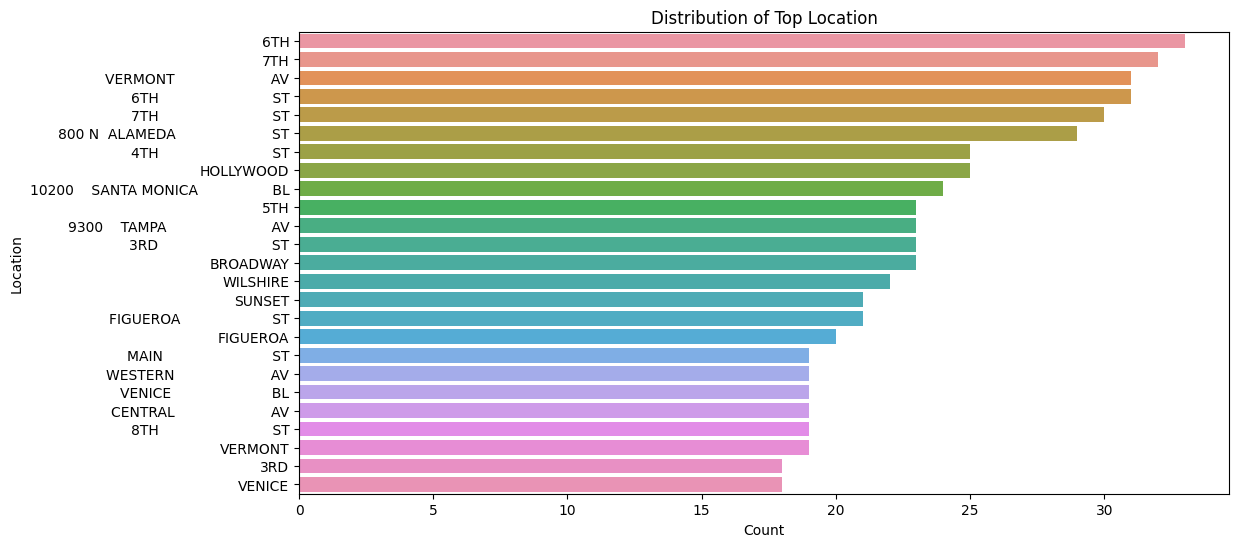

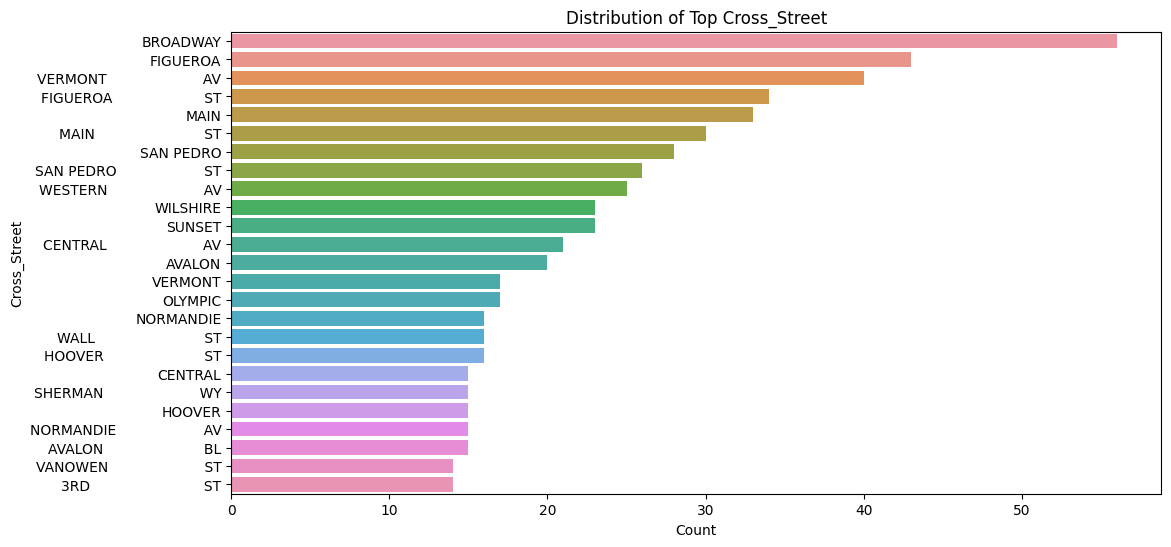

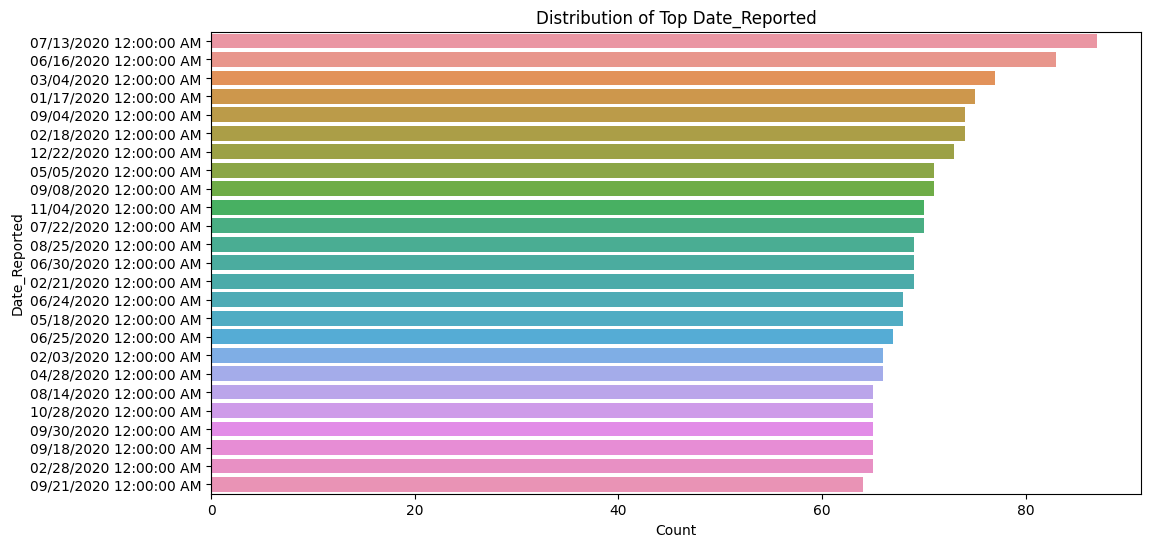

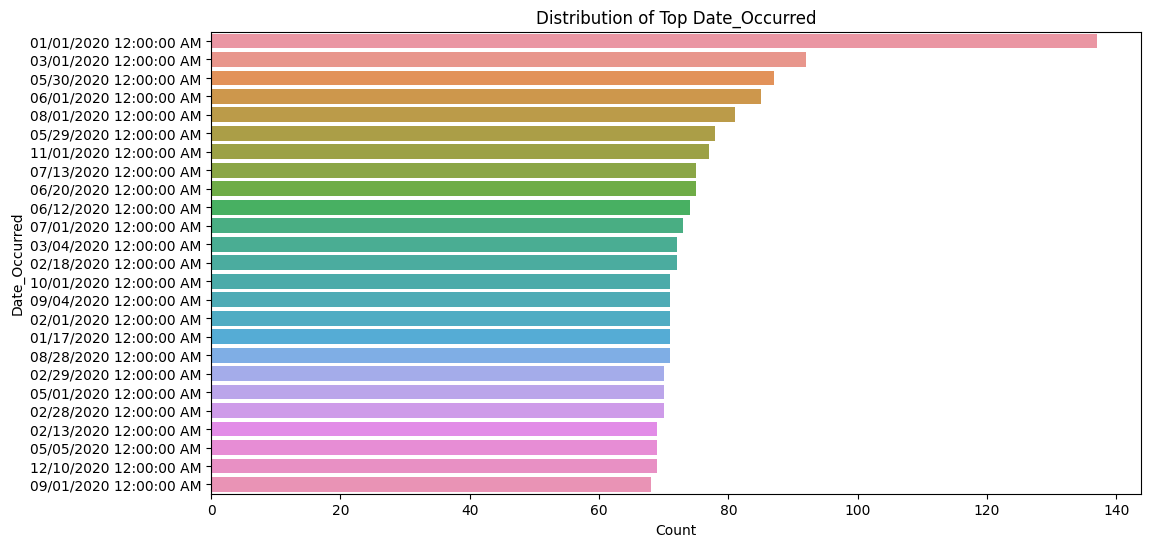

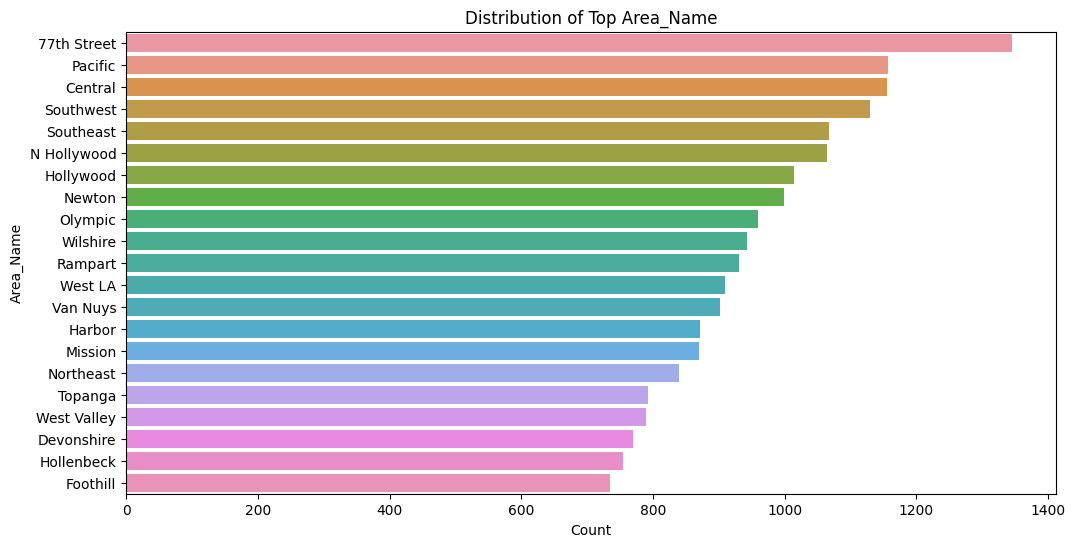

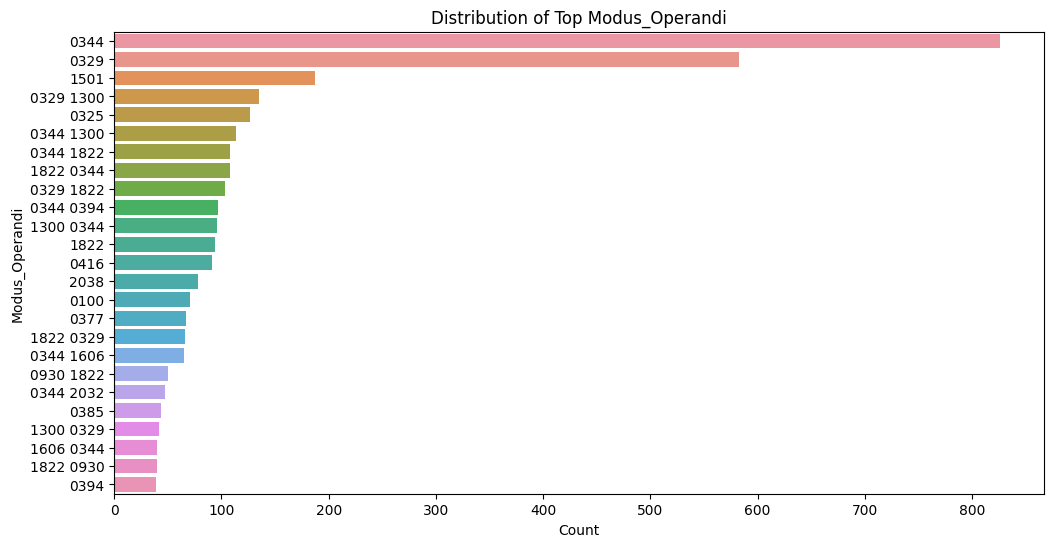

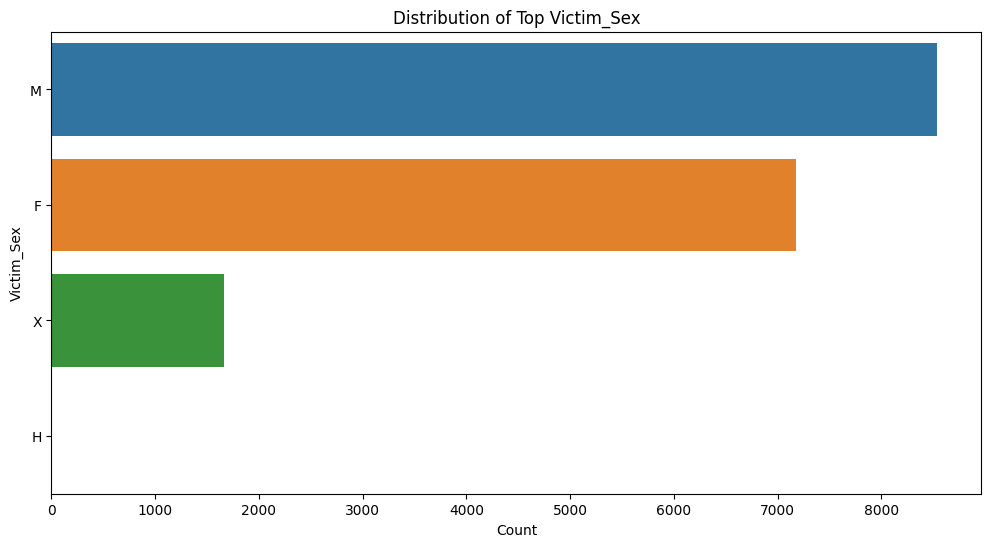

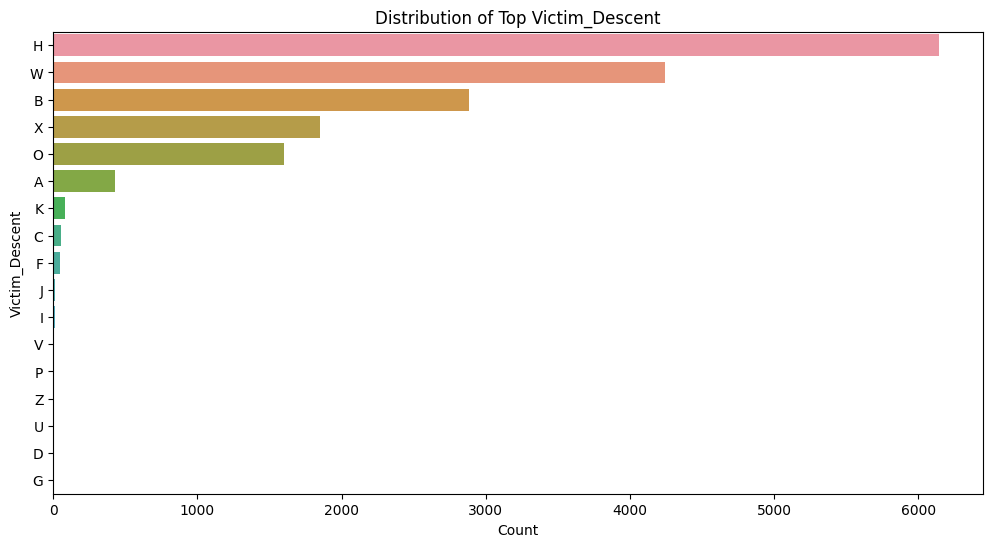

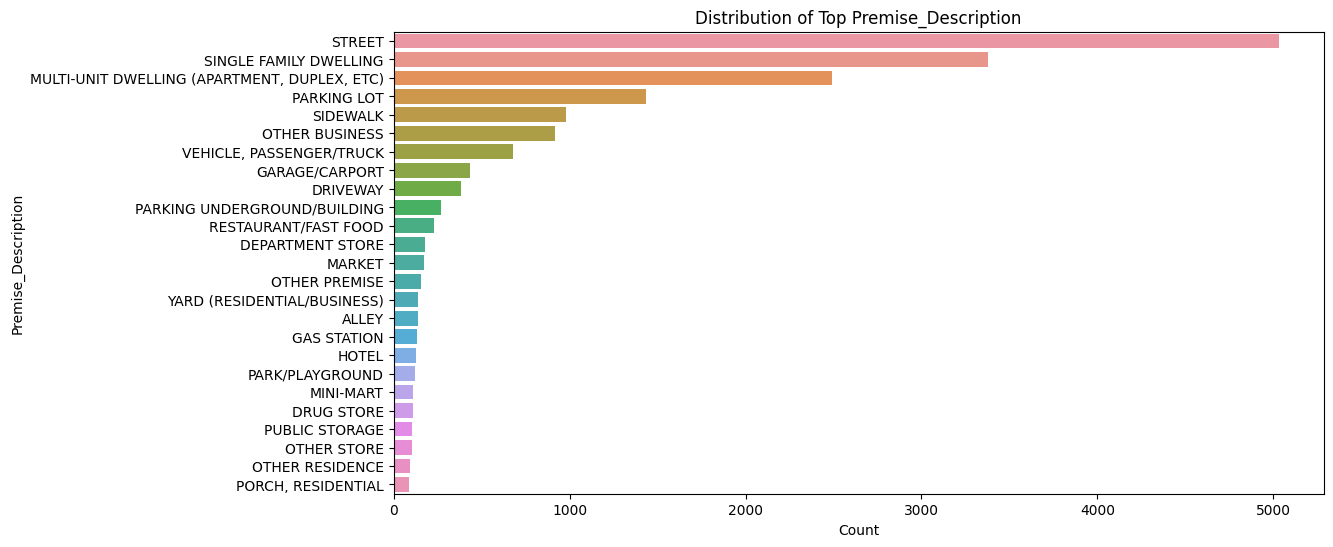

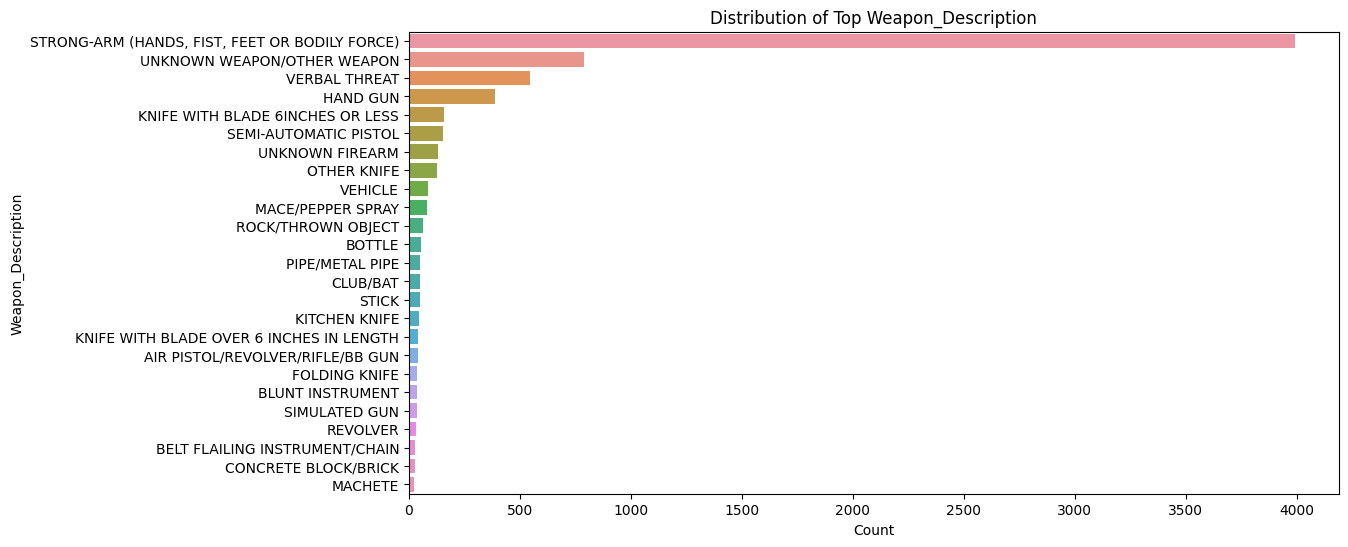

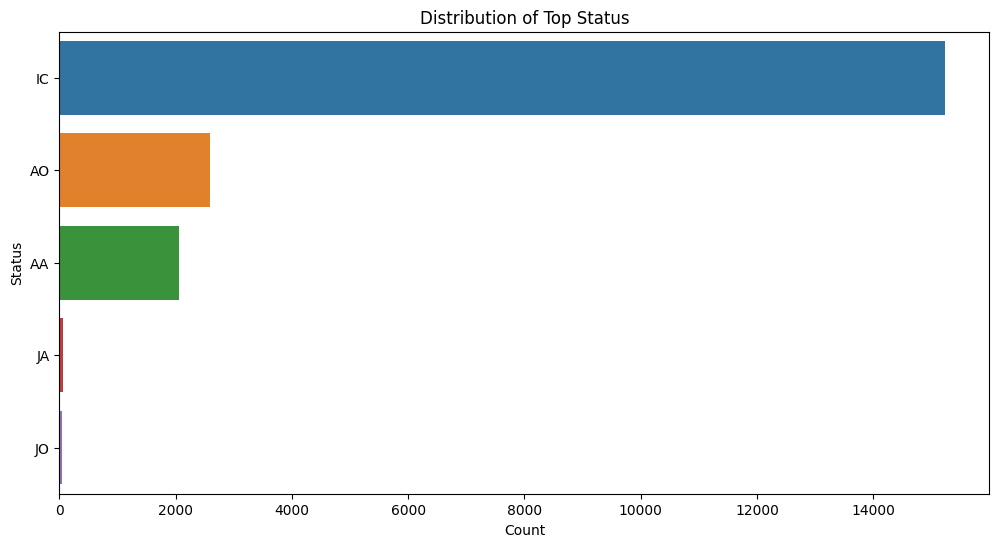

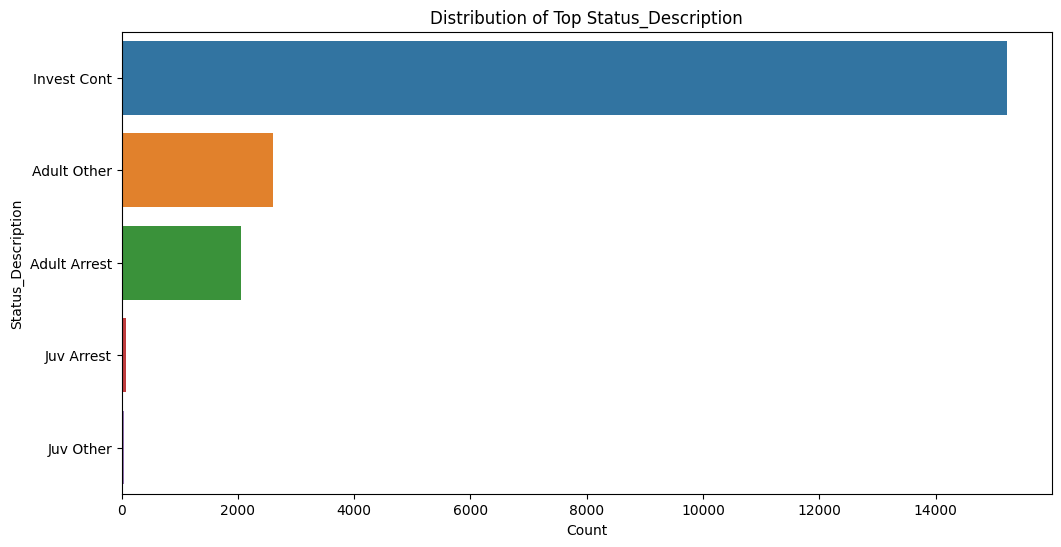

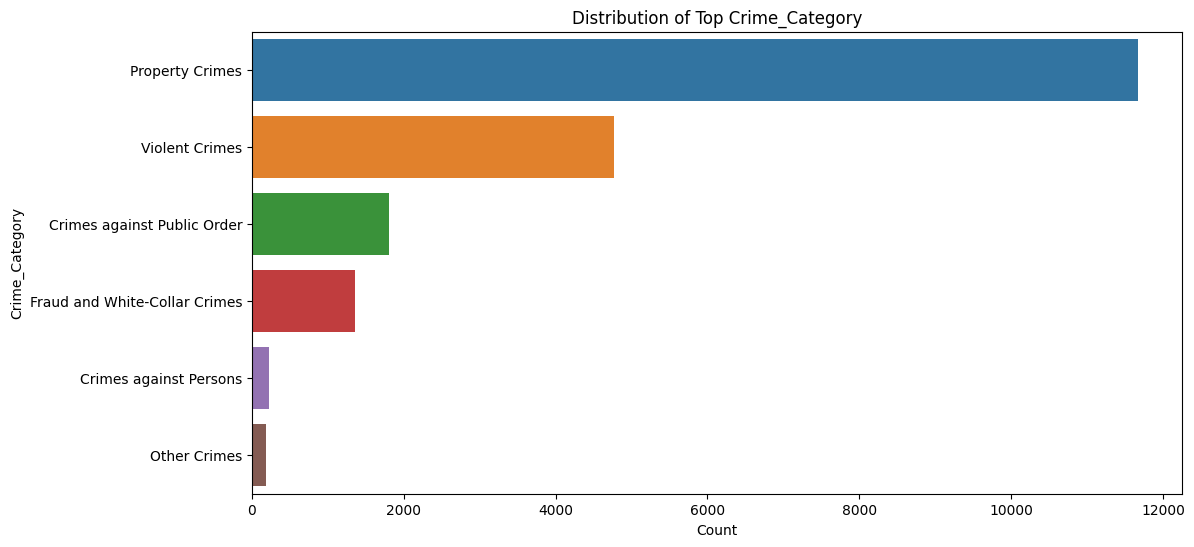

In [13]:
def plotting(df, column, top_n=25):
    #the top 25 value counts of the column,in descending order
    top_categories = df[column].value_counts().nlargest(top_n)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=top_categories.values, y=top_categories.index)
    plt.title(f'Distribution of Top {column}')
    plt.xlabel('Count')
    plt.ylabel(column)
    plt.show()

#for all categorical columns
for column in categorical_columns:
    plotting(train_df, column, top_n=25)

In [14]:
train_df.isna().sum()

Location                     0
Cross_Street             16552
Latitude                     0
Longitude                    0
Date_Reported                0
Date_Occurred                0
Time_Occurred                0
Area_ID                      0
Area_Name                    0
Reporting_District_no        0
Part 1-2                     0
Modus_Operandi            2741
Victim_Age                   0
Victim_Sex                2624
Victim_Descent            2624
Premise_Code                 0
Premise_Description          5
Weapon_Used_Code         12665
Weapon_Description       12665
Status                       0
Status_Description           0
Crime_Category               0
dtype: int64

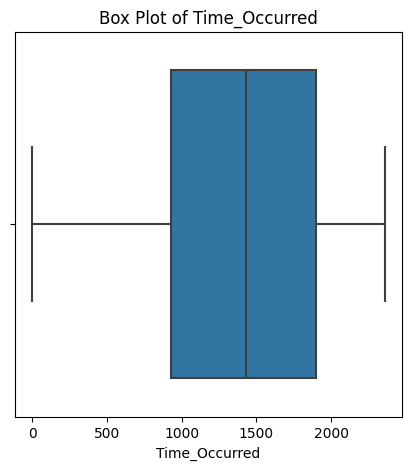

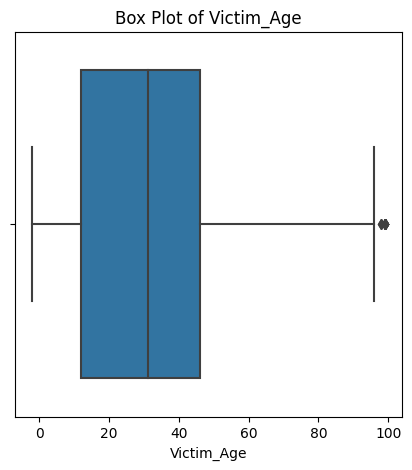

In [15]:
numerical_columns = [ 'Time_Occurred', 'Victim_Age' ]
for column in numerical_columns:
    plt.figure(figsize=(5, 5))
    sns.boxplot(x=train_df[column])
    plt.title(f'Box Plot of {column}')
    plt.show()

# Processing columns

In [16]:
# Calculate the frequency of each category in Victim_Descent
victim_descent_counts = train_df['Victim_Descent'].value_counts()

# Calculate the percentage of each category
victim_descent_percentages = (victim_descent_counts / len(train_df)) * 100

# Get the categories that are below 20% occurrence
low_percentage_categories = victim_descent_percentages[victim_descent_percentages < 5].index 

In [17]:
low_percentage_categories

Index(['A', 'K', 'C', 'F', 'J', 'I', 'V', 'P', 'Z', 'U', 'D', 'G'], dtype='object', name='Victim_Descent')

In [18]:
# Replace these categories with 'Z' for combined
train_df['Victim_Descent'] = train_df['Victim_Descent'].apply(lambda x: 'Z' if x in low_percentage_categories else x)

print(train_df['Victim_Descent'].value_counts())

Victim_Descent
H    6143
W    4245
B    2881
X    1849
O    1603
Z     655
Name: count, dtype: int64


In [19]:
train_df['Date_Reported'].head()

0    03/09/2020 12:00:00 AM
1    02/27/2020 12:00:00 AM
2    08/21/2020 12:00:00 AM
3    11/08/2020 12:00:00 AM
4    02/25/2020 12:00:00 AM
Name: Date_Reported, dtype: object

In [20]:
# Convert the 'Date_Reported' and 'Date_Occurred' columns to datetime
train_df['Date_Reported'] = pd.to_datetime(train_df['Date_Reported'], format='%m/%d/%Y %I:%M:%S %p')
train_df['Date_Occurred'] = pd.to_datetime(train_df['Date_Occurred'], format='%m/%d/%Y %I:%M:%S %p')

test_df['Date_Reported'] = pd.to_datetime(test_df['Date_Reported'], format='%m/%d/%Y %I:%M:%S %p')
test_df['Date_Occurred'] = pd.to_datetime(test_df['Date_Occurred'], format='%m/%d/%Y %I:%M:%S %p')

In [21]:
train_df['Reported_Year'] = train_df['Date_Reported'].dt.year
train_df['Reported_Month'] = train_df['Date_Reported'].dt.month
train_df['Reported_Day'] = train_df['Date_Reported'].dt.day
train_df['Reported_Weekday'] = train_df['Date_Reported'].dt.weekday  # Monday=0, Sunday=6

train_df['Occurred_Year'] = train_df['Date_Occurred'].dt.year
train_df['Occurred_Month'] = train_df['Date_Occurred'].dt.month
train_df['Occurred_Day'] = train_df['Date_Occurred'].dt.day
train_df['Occurred_Weekday'] = train_df['Date_Occurred'].dt.weekday  # Monday=0, Sunday=6

In [22]:
test_df['Reported_Year'] = test_df['Date_Reported'].dt.year
test_df['Reported_Month'] = test_df['Date_Reported'].dt.month
test_df['Reported_Day'] = test_df['Date_Reported'].dt.day
test_df['Reported_Weekday'] = test_df['Date_Reported'].dt.weekday  # Monday=0, Sunday=6

test_df['Occurred_Year'] = test_df['Date_Occurred'].dt.year
test_df['Occurred_Month'] = test_df['Date_Occurred'].dt.month
test_df['Occurred_Day'] = test_df['Date_Occurred'].dt.day
test_df['Occurred_Weekday'] = test_df['Date_Occurred'].dt.weekday  # Monday=0, Sunday=6

# add dist plot .. to check exact dist


In [23]:
# Calculate the difference in days
train_df['Days_Difference'] = (train_df['Date_Reported'] - train_df['Date_Occurred']).dt.days
test_df['Days_Difference'] = (test_df['Date_Reported'] - test_df['Date_Occurred']).dt.days
# Compute the average number of days
average_days_difference = train_df['Days_Difference'].mean()
print(f'The average number of days between Date_Occurred and Date_Reported is {average_days_difference:.2f} days.')

The average number of days between Date_Occurred and Date_Reported is 22.12 days.


In [24]:
a = train_df['Days_Difference'].max()
a

1437

In [25]:
rows_with_max_difference = train_df[train_df['Days_Difference'] == a]

# Extract the Date_Occurred and Date_Reported values for these rows
max_difference_details = rows_with_max_difference[['Date_Occurred', 'Date_Reported', 'Days_Difference']]

print(max_difference_details)

      Date_Occurred Date_Reported  Days_Difference
16796    2020-01-01    2023-12-08             1437


In [26]:
def time_to_seconds(time):
    hours = time // 100
    minutes = time % 100
    return hours * 3600 + minutes * 60

In [27]:
train_df['Time_Occurred'] = train_df['Time_Occurred'].apply(time_to_seconds)

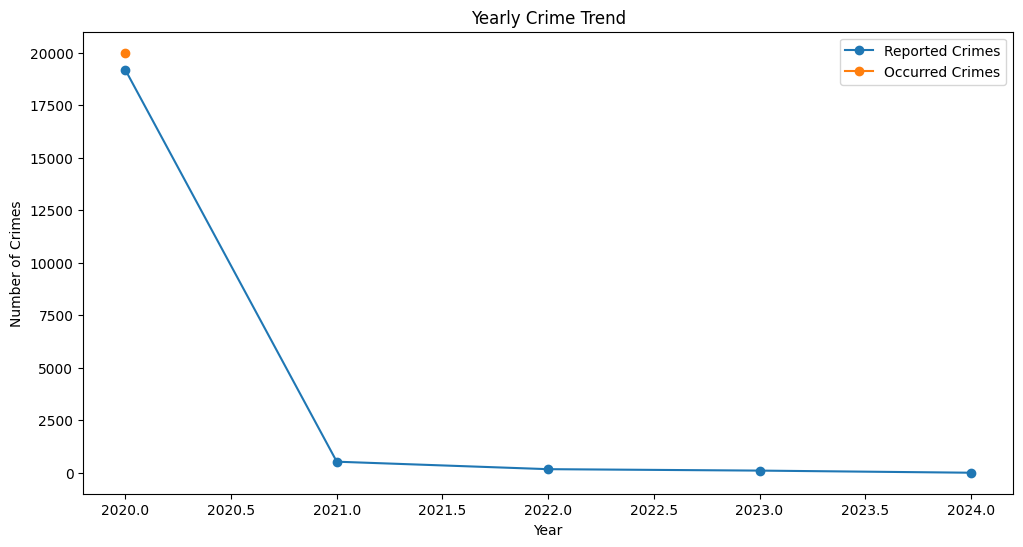

In [28]:
# Yearly Analysis
yearly_reported = train_df.groupby('Reported_Year').size()
yearly_occurred = train_df.groupby('Occurred_Year').size()

plt.figure(figsize=(12, 6))
plt.plot(yearly_reported.index, yearly_reported.values, label='Reported Crimes', marker='o')
plt.plot(yearly_occurred.index, yearly_occurred.values, label='Occurred Crimes', marker='o')
plt.title('Yearly Crime Trend')
plt.xlabel('Year')
plt.ylabel('Number of Crimes')
plt.legend()
plt.show()

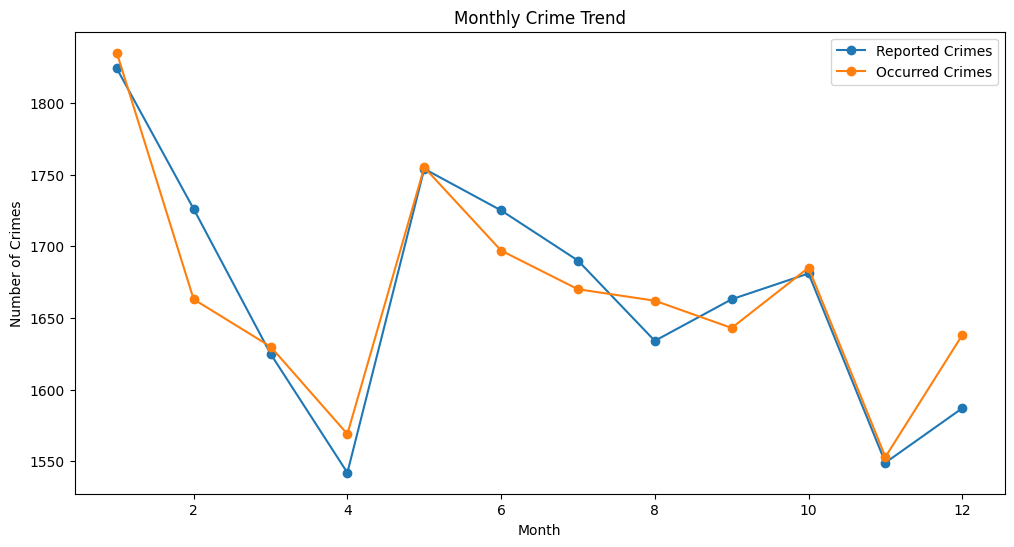

In [29]:
# Monthly Analysis
monthly_reported = train_df.groupby('Reported_Month').size()
monthly_occurred = train_df.groupby('Occurred_Month').size()

plt.figure(figsize=(12, 6))
plt.plot(monthly_reported.index, monthly_reported.values, label='Reported Crimes', marker='o')
plt.plot(monthly_occurred.index, monthly_occurred.values, label='Occurred Crimes', marker='o')
plt.title('Monthly Crime Trend')
plt.xlabel('Month')
plt.ylabel('Number of Crimes')
plt.legend()
plt.show()

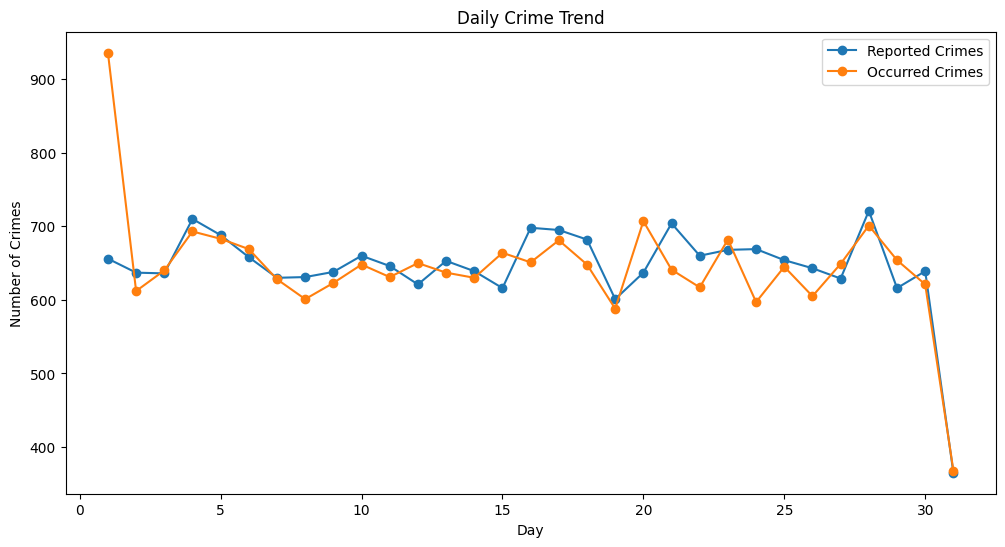

In [30]:
# Daily Analysis
daily_reported = train_df.groupby('Reported_Day').size()
daily_occurred = train_df.groupby('Occurred_Day').size()

plt.figure(figsize=(12, 6))
plt.plot(daily_reported.index, daily_reported.values, label='Reported Crimes', marker='o')
plt.plot(daily_occurred.index, daily_occurred.values, label='Occurred Crimes', marker='o')
plt.title('Daily Crime Trend')
plt.xlabel('Day')
plt.ylabel('Number of Crimes')
plt.legend()
plt.show()

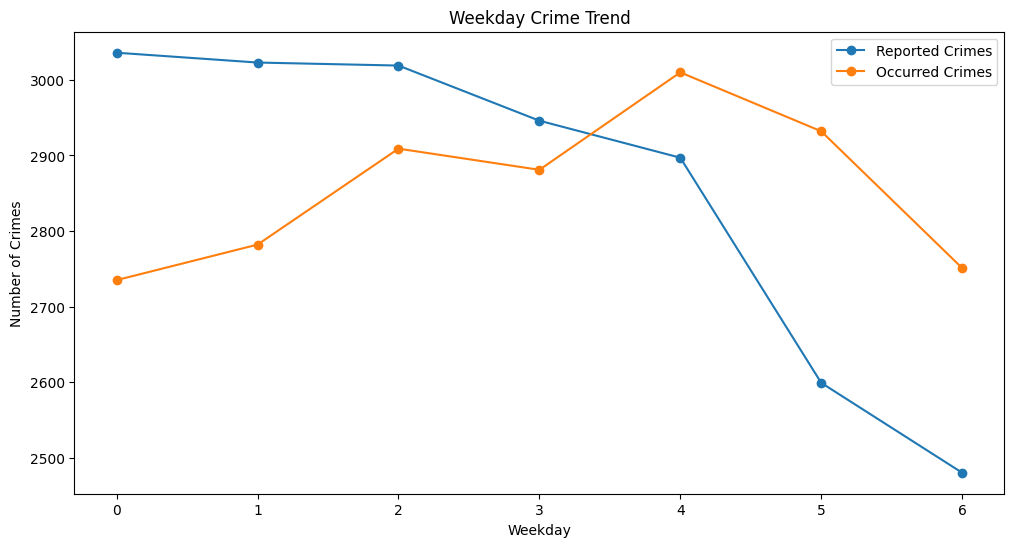

In [31]:
# Weekday Analysis
weekday_reported = train_df.groupby('Reported_Weekday').size()
weekday_occurred = train_df.groupby('Occurred_Weekday').size()

plt.figure(figsize=(12, 6))
plt.plot(weekday_reported.index, weekday_reported.values, label='Reported Crimes', marker='o')
plt.plot(weekday_occurred.index, weekday_occurred.values, label='Occurred Crimes', marker='o')
plt.title('Weekday Crime Trend')
plt.xlabel('Weekday')
plt.ylabel('Number of Crimes')
plt.legend()
plt.show()

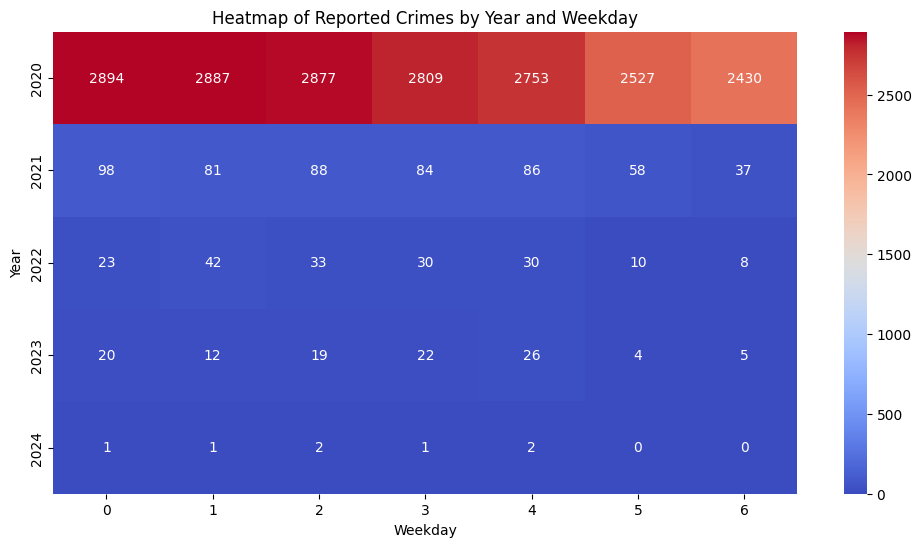

In [32]:
weekly_heatmap_reported = train_df.pivot_table(index='Reported_Year', columns='Reported_Weekday', aggfunc='size', fill_value=0)
plt.figure(figsize=(12, 6))
sns.heatmap(weekly_heatmap_reported, cmap='coolwarm', annot=True, fmt='d')
plt.title('Heatmap of Reported Crimes by Year and Weekday')
plt.xlabel('Weekday')
plt.ylabel('Year')
plt.show()

In [33]:
#identifying all rows where 'Victim_Age' is less than or equal to 0.
incorrect_age_mask = (train_df['Victim_Age'] <= 0)
median_age = train_df.loc[~incorrect_age_mask, 'Victim_Age'].median()
train_df.loc[incorrect_age_mask, 'Victim_Age'] = median_age

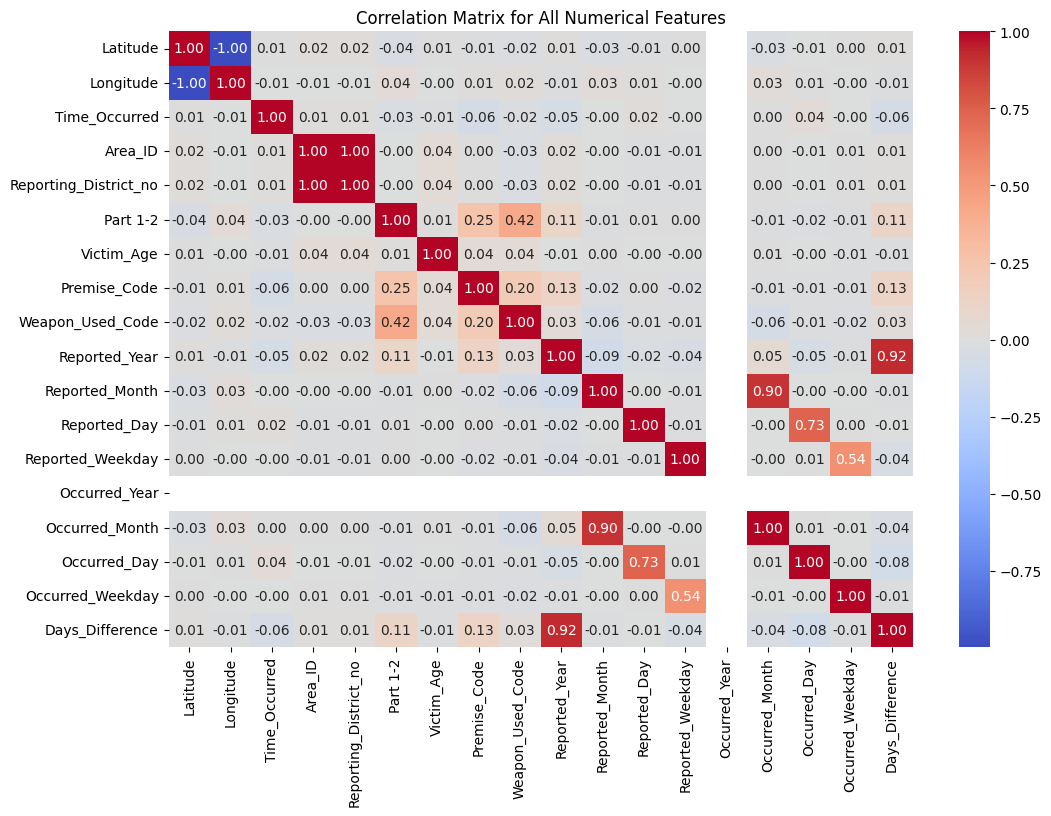

In [34]:
numerical_columns = ['Latitude', 'Longitude', 'Time_Occurred', 'Area_ID', 'Reporting_District_no', 
                     'Part 1-2', 'Victim_Age', 'Premise_Code', 'Weapon_Used_Code', 'Reported_Year', 
                     'Reported_Month', 'Reported_Day', 'Reported_Weekday', 'Occurred_Year', 
                     'Occurred_Month', 'Occurred_Day', 'Occurred_Weekday', 'Days_Difference']
correlation_matrix = train_df[numerical_columns].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix for All Numerical Features')
plt.show()

#Reporting_District_no and Area_ID are highly correlated, a one-to-one relation exists.

In [35]:
target = train_df['Crime_Category']
distribution = target.value_counts()
print(distribution)

Crime_Category
Property Crimes                  11666
Violent Crimes                    4767
Crimes against Public Order       1808
Fraud and White-Collar Crimes     1355
Crimes against Persons             225
Other Crimes                       179
Name: count, dtype: int64


In [36]:
#for categorical: chi2 test
results = []
for column in categorical_columns:
    contingency_table = pd.crosstab(train_df['Crime_Category'], train_df[column])
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    
    results.append({
        'Feature': column,
        'Chi-Squared Statistic': chi2_stat,
        'P-Value': p_value
    })
results_df = pd.DataFrame(results)
print(results_df)

                Feature  Chi-Squared Statistic        P-Value
0              Location           66269.777425   6.861030e-33
1          Cross_Street            7236.374964   9.729601e-01
2         Date_Reported            8464.564304   0.000000e+00
3         Date_Occurred            2073.079225   3.996968e-05
4             Area_Name             615.189665   4.122622e-75
5        Modus_Operandi           76372.563791   0.000000e+00
6            Victim_Sex            1087.357348  2.489762e-222
7        Victim_Descent            1845.953522   0.000000e+00
8   Premise_Description            7301.689703   0.000000e+00
9    Weapon_Description            5694.708722   0.000000e+00
10               Status            3715.561535   0.000000e+00
11   Status_Description            3715.561535   0.000000e+00
12       Crime_Category          100000.000000   0.000000e+00


Chi-Squared statistic measures the difference between the observed and expected frequencies of categorical variables. Higher the value, more disrepancies and better association

Except Cross_Street , Highly significant relationship exists. The null hypothesis is rejected, indicating an association with the target variable.

In [37]:
# Assuming your DataFrame is named train_df
numerical_columns = train_df.select_dtypes(include=['int64', 'float64']).columns
print("Numerical columns:", numerical_columns)

Numerical columns: Index(['Latitude', 'Longitude', 'Time_Occurred', 'Area_ID',
       'Reporting_District_no', 'Part 1-2', 'Victim_Age', 'Premise_Code',
       'Weapon_Used_Code', 'Days_Difference'],
      dtype='object')


In [38]:
#for numerical: f test
for feature in numerical_columns:
    groups = [group[feature].values for name, group in train_df.groupby('Crime_Category')]
    f_statistic, p_value = f_oneway(*groups)
    print(f'F: {feature}:  {f_statistic},{p_value}')

F: Latitude:  10.872653671577844,1.823945141213922e-10
F: Longitude:  10.66518583639656,2.975789672985393e-10
F: Time_Occurred:  17.092853388223983,6.54895358700745e-17
F: Area_ID:  2.1042012077359233,0.06179568895365559
F: Reporting_District_no:  2.25570118555336,0.04617107188065863
F: Part 1-2:  2425.605288227544,0.0
F: Victim_Age:  175.25111588211007,3.867915846247545e-183
F: Premise_Code:  388.0361432071709,0.0
F: Weapon_Used_Code:  nan,nan
F: Days_Difference:  565.6304187916692,0.0


Occurred_Year is constant, Reported_Day feature does not show any significant association.




# Splitting

In [39]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Location               20000 non-null  object        
 1   Cross_Street           3448 non-null   object        
 2   Latitude               20000 non-null  float64       
 3   Longitude              20000 non-null  float64       
 4   Date_Reported          20000 non-null  datetime64[ns]
 5   Date_Occurred          20000 non-null  datetime64[ns]
 6   Time_Occurred          20000 non-null  float64       
 7   Area_ID                20000 non-null  float64       
 8   Area_Name              20000 non-null  object        
 9   Reporting_District_no  20000 non-null  float64       
 10  Part 1-2               20000 non-null  float64       
 11  Modus_Operandi         17259 non-null  object        
 12  Victim_Age             20000 non-null  float64       
 13  V

In [40]:
train_df = train_df.drop(['Occurred_Year','Reported_Day','Date_Occurred','Date_Reported','Location','Cross_Street','Area_Name','Weapon_Description', 'Premise_Description','Status_Description'], axis=1)
test_df = test_df.drop(['Occurred_Year','Reported_Day','Date_Occurred','Date_Reported','Location','Cross_Street','Area_Name', 'Weapon_Description', 'Premise_Description','Status_Description'], axis=1)

In [41]:
train_df.columns

Index(['Latitude', 'Longitude', 'Time_Occurred', 'Area_ID',
       'Reporting_District_no', 'Part 1-2', 'Modus_Operandi', 'Victim_Age',
       'Victim_Sex', 'Victim_Descent', 'Premise_Code', 'Weapon_Used_Code',
       'Status', 'Crime_Category', 'Reported_Year', 'Reported_Month',
       'Reported_Weekday', 'Occurred_Month', 'Occurred_Day',
       'Occurred_Weekday', 'Days_Difference'],
      dtype='object')

In [42]:
train_df['Modus_Operandi'] = train_df['Modus_Operandi'].fillna('').astype(str)
test_df['Modus_Operandi'] = test_df['Modus_Operandi'].fillna('').astype(str)

In [43]:
train_df['Modus_Operandi_list'] = train_df['Modus_Operandi'].apply(lambda x: x.split())
test_df['Modus_Operandi_list'] = test_df['Modus_Operandi'].apply(lambda x: x.split())
train_df.drop(columns=['Modus_Operandi'], inplace=True)
test_df.drop(columns=['Modus_Operandi'], inplace=True)

In [44]:
train_df.Modus_Operandi_list.isna().sum()

0

In [45]:
X_train_full = train_df.drop('Crime_Category', axis=1)
y_train_full = train_df['Crime_Category']
X_test = test_df 

In [46]:
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42)

In [47]:
print("Before resampling:", Counter(y_train))

Before resampling: Counter({'Property Crimes': 9333, 'Violent Crimes': 3814, 'Crimes against Public Order': 1446, 'Fraud and White-Collar Crimes': 1084, 'Crimes against Persons': 180, 'Other Crimes': 143})


In [48]:
X_test.shape

(5000, 20)

In [49]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16000 entries, 6735 to 554
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Latitude               16000 non-null  float64
 1   Longitude              16000 non-null  float64
 2   Time_Occurred          16000 non-null  float64
 3   Area_ID                16000 non-null  float64
 4   Reporting_District_no  16000 non-null  float64
 5   Part 1-2               16000 non-null  float64
 6   Victim_Age             16000 non-null  float64
 7   Victim_Sex             13902 non-null  object 
 8   Victim_Descent         13902 non-null  object 
 9   Premise_Code           16000 non-null  float64
 10  Weapon_Used_Code       5859 non-null   float64
 11  Status                 16000 non-null  object 
 12  Reported_Year          16000 non-null  int32  
 13  Reported_Month         16000 non-null  int32  
 14  Reported_Weekday       16000 non-null  int32  
 15  Occurr

In [50]:
X_val.shape

(4000, 20)

In [51]:
X_train.head()

,Latitude,Longitude,Time_Occurred,Area_ID,Reporting_District_no,Part 1-2,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Weapon_Used_Code,Status,Reported_Year,Reported_Month,Reported_Weekday,Occurred_Month,Occurred_Day,Occurred_Weekday,Days_Difference,Modus_Operandi_list
6735,33.9599,-118.3805,11100.0,14.0,1488.0,2.0,37.0,X,X,210.0,NaN,IC,2020,2,3,2,13,3,0,"[1402, 0329, 0907]"
14589,34.0486,-118.2571,31500.0,1.0,152.0,1.0,37.0,NaN,NaN,108.0,NaN,IC,2020,11,3,11,12,3,0,[]
12931,34.0553,-118.3919,72600.0,8.0,857.0,2.0,17.0,M,W,102.0,400.0,JO,2020,10,0,10,26,0,0,"[0400, 1251, 0444, 0446, 1259, 2024]"
16521,33.9916,-118.4162,64800.0,14.0,1457.0,1.0,37.0,X,X,301.0,NaN,IC,2020,8,1,8,14,4,4,[0344]
17461,34.0193,-118.4059,73200.0,14.0,1406.0,1.0,37.0,NaN,NaN,101.0,NaN,IC,2020,1,1,1,13,0,1,[]


# Processing

In [52]:
from sklearn.preprocessing import MultiLabelBinarizer

In [53]:
mlb = MultiLabelBinarizer()
X_train_modus = mlb.fit_transform(X_train['Modus_Operandi_list'])
X_val_modus = mlb.transform(X_val['Modus_Operandi_list'])
X_test_modus = mlb.transform(X_test['Modus_Operandi_list'])

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['0117', '0372', '0383', '0391', '0855', '0902', '1012', '1224', '1225', '1230', '1316', '1405', '1522', '1538', '1903', '2011', '2019', '2022', '2023', '2025', '2104', '2304', '4025'] will be ignored
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['0218', '0306', '0320', '0372', '0383', '0393', '0403', '0518', '0540', '0854', '1011', '1225', '1230', '1231', '1255', '1314', '1316', '1903', '2011', '2019', '2022', '2023', '2026', '2043', '2044', '2208', '2308', '3030'] will be ignored
  warnings.warn(


In [54]:
# Convert the result to DataFrames
encoded_train_modus_df = pd.DataFrame(X_train_modus, columns=mlb.classes_, index=X_train.index)
encoded_val_modus_df = pd.DataFrame(X_val_modus, columns=mlb.classes_,index=X_val.index)
encoded_test_modus_df = pd.DataFrame(X_test_modus, columns=mlb.classes_,index=X_test.index)

In [55]:
print("X_train_modus shape:", X_train_modus.shape)
print("X_val_modus shape:", X_val_modus.shape)
print("X_test_modus shape:", X_test_modus.shape)

X_train_modus shape: (16000, 458)
X_val_modus shape: (4000, 458)
X_test_modus shape: (5000, 458)


In [56]:
# Ensure all DataFrames have the same columns
common_columns = list(set(encoded_train_modus_df.columns) & set(encoded_val_modus_df.columns) & set(encoded_test_modus_df.columns))

# Reindex the DataFrames with the common columns
encoded_train_modus_df = encoded_train_modus_df[common_columns]
encoded_val_modus_df = encoded_val_modus_df[common_columns]
encoded_test_modus_df = encoded_test_modus_df[common_columns]

In [57]:
encoded_train_modus_df.fillna(0, inplace=True)
encoded_val_modus_df.fillna(0, inplace=True)
encoded_test_modus_df.fillna(0, inplace=True)

In [58]:
numerical_cols = X_train.select_dtypes(include=['number']).columns
print("Numerical columns:")
print(numerical_cols)

# Select categorical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns
print("\nCategorical columns:")
print(categorical_cols)

Numerical columns:
Index(['Latitude', 'Longitude', 'Time_Occurred', 'Area_ID',
       'Reporting_District_no', 'Part 1-2', 'Victim_Age', 'Premise_Code',
       'Weapon_Used_Code', 'Reported_Year', 'Reported_Month',
       'Reported_Weekday', 'Occurred_Month', 'Occurred_Day',
       'Occurred_Weekday', 'Days_Difference'],
      dtype='object')

Categorical columns:
Index(['Victim_Sex', 'Victim_Descent', 'Status', 'Modus_Operandi_list'], dtype='object')


In [59]:
numerical_columns = ['Latitude', 'Longitude', 'Time_Occurred', 'Area_ID',
       'Reporting_District_no', 'Part 1-2', 'Victim_Age', 'Premise_Code',
       'Weapon_Used_Code', 'Reported_Year', 'Reported_Month', 
       'Reported_Weekday',  'Occurred_Month', 'Occurred_Day',
       'Occurred_Weekday', 'Days_Difference']
#'Occurred_Year' 'Reported_Day',
categorical_columns = [
   'Victim_Sex', 'Victim_Descent', 'Status']
#text_columns = ['Modus_Operandi_list']

In [60]:
final_train_df = pd.concat([
    X_train[numerical_columns],  # processed numerical features
    X_train[categorical_columns],  # processed categorical features
    encoded_train_modus_df
], axis=1)

final_val_df = pd.concat([
    X_val[numerical_columns],  # processed numerical features
    X_val[categorical_columns],  # processed categorical features
    encoded_val_modus_df
], axis=1)

final_test_df = pd.concat([
    X_test[numerical_columns],  # processed numerical features
    X_test[categorical_columns],  # processed categorical features
    encoded_test_modus_df
], axis=1)

In [61]:
final_train_df.head()

,Latitude,Longitude,Time_Occurred,Area_ID,Reporting_District_no,Part 1-2,Victim_Age,Premise_Code,Weapon_Used_Code,Reported_Year,...,2051,1302,2201,0416,0349,0538,1222,1610,2056,0358
6735,33.9599,-118.3805,11100.0,14.0,1488.0,2.0,37.0,210.0,NaN,2020,...,0,0,0,0,0,0,0,0,0,0
14589,34.0486,-118.2571,31500.0,1.0,152.0,1.0,37.0,108.0,NaN,2020,...,0,0,0,0,0,0,0,0,0,0
12931,34.0553,-118.3919,72600.0,8.0,857.0,2.0,17.0,102.0,400.0,2020,...,0,0,0,0,0,0,0,0,0,0
16521,33.9916,-118.4162,64800.0,14.0,1457.0,1.0,37.0,301.0,NaN,2020,...,0,0,0,0,0,0,0,0,0,0
17461,34.0193,-118.4059,73200.0,14.0,1406.0,1.0,37.0,101.0,NaN,2020,...,0,0,0,0,0,0,0,0,0,0


In [62]:
final_test_df.shape

(5000, 477)

In [63]:
all_columns = final_train_df.columns
remaining_columns = [col for col in all_columns if col not in numerical_columns + categorical_columns]

In [64]:
#categorical columns to string for confirmation
for col in categorical_columns:
    final_train_df[col] = final_train_df[col].astype(str)
    final_val_df[col] = final_val_df[col].astype(str)
    final_test_df[col] = final_test_df[col].astype(str)

In [65]:
# Define transformers with imputation and scaling
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore',max_categories=10,sparse_output=False))
])

remaining_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns),
        ('remaining', remaining_transformer, remaining_columns)
    ],
     remainder='passthrough'
)

In [66]:
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit and transform the target variable for training and validation sets
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

category_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print(category_mapping)

{'Crimes against Persons': 0, 'Crimes against Public Order': 1, 'Fraud and White-Collar Crimes': 2, 'Other Crimes': 3, 'Property Crimes': 4, 'Violent Crimes': 5}


In [67]:
y_train.shape

(16000,)

In [68]:
y_val_encoded

array([5, 4, 4, ..., 4, 4, 2])

In [69]:
# Replace NaNs with 0
final_train_df = pd.DataFrame(final_train_df).fillna(0)
final_val_df = pd.DataFrame(final_val_df).fillna(0)
final_test_df = pd.DataFrame(final_test_df).fillna(0)

# Verify
print("NaNs in final_train_df:", final_train_df.isna().sum().sum())
print("NaNs in final_val_df:", final_val_df.isna().sum().sum())
print("NaNs in final_test_df:", final_test_df.isna().sum().sum())


NaNs in final_train_df: 0
NaNs in final_val_df: 0
NaNs in final_test_df: 0


In [70]:
X_train_processed = preprocessor.fit_transform(final_train_df)
X_val_processed = preprocessor.transform(final_val_df)
X_test_processed = preprocessor.transform(final_test_df)

In [71]:
print(f"X_train_processed shape: {X_train_processed.shape}")
print(f"y_train_encoded shape: {y_train_encoded.shape}")

X_train_processed shape: (16000, 491)
y_train_encoded shape: (16000,)


In [72]:
from imblearn.over_sampling import ADASYN

In [73]:
#synthetic samples for the minority class
adasyn = ADASYN(random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train_processed, y_train_encoded)

print("ADASYN Resampled class distribution:", Counter(y_train_resampled))

ADASYN Resampled class distribution: Counter({1: 9650, 4: 9333, 2: 9316, 0: 9300, 3: 9299, 5: 9055})


# Model building

In [74]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

In [75]:
# Initialize models and their parameter grids
models_param_grids = {
    'Logistic Regression': (
        LogisticRegression(max_iter=6000, random_state=42),
        {
            'C': [0.1, 1, 10, 100],             #small C, strong regularization
            'solver': ['liblinear', 'saga']     #small ds,Stochastic average grad descent- both L1 L2 penalties
        }
    ),
    'K-Nearest Neighbors': (
        KNeighborsClassifier(),
        {
            'n_neighbors': [5, 10, 15, 20],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }
    ),
    # 'Support Vector Classifier': (
    #     SVC(probability=True, random_state=42),
    #     {
    #         'C': [0.1, 1, 10, 100],
    #         'kernel': ['linear', 'rbf']
    #     }
    # ),
    'Random Forest': (
        RandomForestClassifier(random_state=42), 
        {
            'n_estimators': [100, 200],   # no of trees
            'max_depth': [10, 20],   #if none,expand till all leaves pure/leaves have < min_samples_split samples 
            'min_samples_split': [2, 5], # to split the internal nodes
            'min_samples_leaf': [1, 2]   #per leaf node
        }
    ),
    'Gradient Boosting': (
        GradientBoostingClassifier(random_state=42),
        {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1, 0.2]
        }
    ), 
    'Multi-Layer Perceptron': (
        MLPClassifier(max_iter=2000, random_state=42, early_stopping=True),
        {
            'hidden_layer_sizes': [(50,), (100,), (100, 50)], # 1 hidden layer with 50 neurons/ 2 layers with 100,50 neurons resp
            'activation': ['relu', 'tanh'],
            'solver': ['adam', 'sgd']                         #stochastic gradient descent
        }
    ),  
    'XGBoost': (   #extreme grad boosting
        XGBClassifier(random_state=42, eval_metric='logloss'),
        {
            'n_estimators': [100, 200],         #no of trees, higher, better performance
            'learning_rate': [0.01, 0.1, 0.2],  #how much the weights of the trees are updated during each iteration
            'max_depth': [3, 6, 9],             # low LR, more generalized,more time
            'subsample': [0.6, 0.8, 1.0],       #fraction of samples for each tree
            'colsample_bytree': [0.6, 0.8, 1.0] #fraction of features for each tree
        }
    )
}

In [76]:
best_models = {}
best_accuracy = 0.0
best_model_name = None

In [77]:
# Example verification of shapes
print(f"X_train_processed shape: {X_train_processed.shape}")
print(f"X_val_processed shape: {X_val_processed.shape}")
print(f"X_test_processed shape: {X_test_processed.shape}")
print(f"y_train shape: {y_train_encoded.shape}")
print(f"y_val shape: {y_val.shape}")
#print(f"y_test shape: {y_test.shape}")

X_train_processed shape: (16000, 491)
X_val_processed shape: (4000, 491)
X_test_processed shape: (5000, 491)
y_train shape: (16000,)
y_val shape: (4000,)


In [78]:
import numpy as np

print("Number of NaNs in X_train_processed:", np.isnan(X_train_processed).sum())

Number of NaNs in X_train_processed: 0


In [79]:
#variance threshold to reduce the number of features, less var-> less contribution
#less var, similar features, don't contribute much
selector = VarianceThreshold(threshold=0.01)
X_train_reduced = selector.fit_transform(X_train_processed)
X_val_reduced = selector.transform(X_val_processed)
X_test_reduced = selector.transform(X_test_processed)

base_estimator = RandomForestClassifier(random_state=42)
rfecv = RFECV(estimator=base_estimator, step=5, cv=StratifiedKFold(3), scoring='accuracy', n_jobs=-1)

# fitting RFECV with the reduced feature set
rfecv.fit(X_train_reduced, y_train_encoded)

X_train_selected = rfecv.transform(X_train_reduced)
X_val_selected = rfecv.transform(X_val_reduced)
X_test_selected = rfecv.transform(X_test_reduced)

print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 68


In [80]:
#smaller subset for hyperparameter tuning
X_train_small, _, y_train_small, _ = train_test_split(X_train_selected, y_train_encoded, test_size=0.8, random_state=42, stratify=y_train_encoded)

In [81]:
X_val_processed.shape

(4000, 491)

In [82]:
X_val_selected.shape

(4000, 68)

In [83]:
X_train_selected.shape

(16000, 68)

In [84]:
X_test_selected.shape

(5000, 68)

In [85]:
y_val_encoded.shape

(4000,)

In [86]:
y_train_encoded.shape

(16000,)

In [87]:
best_models = {}
best_accuracy = 0
best_model_name = None

In [88]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, roc_curve, auc

In [89]:
classes = [0, 1, 2, 3, 4, 5]
n_classes = len(classes)

In [90]:
for name, (model, param_grid) in models_param_grids.items():
    print(f"Processing model: {name}")
    
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, error_score='raise')
    grid_search.fit(X_train_small, y_train_small)
    
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    print(f'{name} - Best parameters: {best_params}, Best cross-validated accuracy: {best_score:.2f}')
    
    # Update with the best parameters
    best_model = model.set_params(**best_params)
    best_model.fit(X_train_selected, y_train_encoded)
    best_models[name] = best_model
    
    # Evaluation on validation set
    y_val_pred = best_model.predict(X_val_selected)
    val_accuracy = accuracy_score(y_val_encoded, y_val_pred)
    print(classification_report(y_val_encoded, y_val_pred,zero_division=1))
    #when a label has no predicted samples, the precision and F-score for that label are set to 0.0 instead of raising a warning
    
    print(f'{name} - Validation accuracy: {val_accuracy:.2f}')

    # for a sample, get probability of belonging to a particular class
    y_val_scores = best_model.predict_proba(X_val_selected)
    
    # Calculate AUC-ROC scores for each class
    roc_auc = {}
    for i in range(n_classes): #for index 0 to 5
        roc_auc[i] = roc_auc_score(y_val_encoded == i, y_val_scores[:, i]) # create entries for true(1) and false(0) samples for ith label
        print(f'Class {i} - AUC-ROC: {roc_auc[i]:.2f}')
    #distinguish between the positive class and the negative class

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_model_name = name
        best_model = best_model
 
print(f'Best model is {best_model_name} with validation accuracy {best_accuracy:.2f}')

Processing model: Logistic Regression
Logistic Regression - Best parameters: {'C': 10, 'solver': 'liblinear'}, Best cross-validated accuracy: 0.92
              precision    recall  f1-score   support

           0       0.76      0.29      0.42        45
           1       0.82      0.76      0.79       362
           2       0.86      0.94      0.89       271
           3       0.44      0.11      0.18        36
           4       0.98      0.98      0.98      2333
           5       0.90      0.94      0.92       953

    accuracy                           0.93      4000
   macro avg       0.79      0.67      0.70      4000
weighted avg       0.93      0.93      0.93      4000

Logistic Regression - Validation accuracy: 0.93
Class 0 - AUC-ROC: 0.95
Class 1 - AUC-ROC: 0.97
Class 2 - AUC-ROC: 1.00
Class 3 - AUC-ROC: 0.95
Class 4 - AUC-ROC: 1.00
Class 5 - AUC-ROC: 0.99
Processing model: K-Nearest Neighbors
K-Nearest Neighbors - Best parameters: {'metric': 'manhattan', 'n_neighbors': 5,

* AUC ROC CURVE for multiclass classification using one-vs-rest approach for performance of a binary classifier, plot for recall (TP against FP)

* Each class is treated as positive while others are negative

## Final 3 models
Random Forest - Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}, Best cross-validated accuracy: 0.93
              precision    recall  f1-score   support

           0       1.00      0.29      0.45        45
           1       0.84      0.78      0.81       362
           2       0.93      0.94      0.93       271
           3       0.50      0.06      0.10        36
           4       0.99      0.98      0.99      2333
           5       0.88      0.98      0.93       953

    accuracy                           0.94      4000
   macro avg       0.86      0.67      0.70      4000
weighted avg       0.94      0.94      0.94      4000

Random Forest - Validation accuracy: 0.94
Class 0 - AUC-ROC: 0.99
Class 1 - AUC-ROC: 0.99
Class 2 - AUC-ROC: 1.00
Class 3 - AUC-ROC: 0.96
Class 4 - AUC-ROC: 1.00
Class 5 - AUC-ROC: 0.99

.................................

Processing model: Gradient Boosting
Gradient Boosting - Best parameters: {'learning_rate': 0.1, 'n_estimators': 100}, Best cross-validated accuracy: 0.94
              precision    recall  f1-score   support

           0       0.73      0.60      0.66        45
           1       0.83      0.81      0.82       362
           2       0.90      0.92      0.91       271
           3       0.45      0.25      0.32        36
           4       0.99      0.98      0.99      2333
           5       0.91      0.96      0.93       953

    accuracy                           0.95      4000
   macro avg       0.80      0.75      0.77      4000
weighted avg       0.94      0.95      0.94      4000

Gradient Boosting - Validation accuracy: 0.95
Class 0 - AUC-ROC: 0.98
Class 1 - AUC-ROC: 0.99
Class 2 - AUC-ROC: 1.00
Class 3 - AUC-ROC: 0.96
Class 4 - AUC-ROC: 1.00
Class 5 - AUC-ROC: 0.99
..................................

XGBoost - Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 100, 'subsample': 1.0}, Best cross-validated accuracy: 0.94
              precision    recall  f1-score   support

           0       0.74      0.51      0.61        45
           1       0.86      0.80      0.83       362
           2       0.90      0.94      0.92       271
           3       0.54      0.19      0.29        36
           4       0.99      0.98      0.99      2333
           5       0.90      0.97      0.93       953

    accuracy                           0.95      4000
   macro avg       0.82      0.73      0.76      4000
weighted avg       0.95      0.95      0.94      4000

XGBoost - Validation accuracy: 0.95
Class 0 - AUC-ROC: 0.99
Class 1 - AUC-ROC: 0.99
Class 2 - AUC-ROC: 1.00
Class 3 - AUC-ROC: 0.97
Class 4 - AUC-ROC: 1.00
Class 5 - AUC-ROC: 1.00

# Models comparison
* All three models have a high validation accuracy (0.94 for Random Forest and 0.95 for both Gradient Boosting and XGBoost).
* Random Forest achieves perfect precision for Class 0 but has a low recall (0.29), indicating it rarely predicts this class despite its precision. Both Gradient Boosting and XGBoost show a better balance of precision and recall for Class 0.
* All models show very strong performance on the more frequent class (Class 4) with precision, recall, and F1-scores near 1.0.
* The weighted average precision and recall for Random Forest are high, but the macro average suggests it might struggle with minority classes


In [91]:
print(f'Best model is {best_model_name} with validation accuracy {best_accuracy:.2f}')

Best model is XGBoost with validation accuracy 0.95


# Predictions with XGBoost (best model with validation accuracy 0.95)


In [92]:
# Predict on the test data
y_test_pred = best_model.predict(X_test_selected)

In [93]:
predictions = label_encoder.inverse_transform(y_test_pred)

# Submission for testing

In [94]:
submission = pd.DataFrame({"ID": np.arange(1,5001),"Crime_Category": predictions} ) 
submission.to_csv('submission.csv',index=False)
print("Submission file created successfully.")

Submission file created successfully.


In [95]:
s=pd.read_csv('/kaggle/input/crime-cast-forecasting-crime-categories/sample.csv')

In [96]:
s.head()

,ID,Crime_Category,Unnamed: 2
0,1,Crimes against Persons,NaN
1,2,Crimes against Public Order,NaN
2,3,Other Crimes,NaN
3,4,Crimes against Public Order,NaN
4,5,Other Crimes,NaN
